# Perturbation modeling with the {class}`~moscot.problems.generic.SinkhornProblem`

In this tutorial, we showcase how to use the generic solver class :class:`~moscot.problems.generic.SinkhornProblem` to model cellular responses to chemical drugs.



## Preliminaries

In [1]:
import warnings
from typing import List, Literal, Optional, Tuple

import moscot as mt
import moscot.plotting as mtp
from moscot.problems.generic import SinkhornProblem
from tqdm.std import TqdmWarning

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", TqdmWarning)

### Dataset description

TODO

In [2]:
adata = mt.datasets.sciplex()
adata

100%|██████████| 2.29G/2.29G [02:23<00:00, 17.1MB/s] 


AnnData object with n_obs × n_vars = 799317 × 110984
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

### Preprocess the data


In [19]:
adata[adata.obs["perturbation"]=='Zileuton']

View of AnnData object with n_obs × n_vars = 4052 × 110984
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [20]:
adata_red = adata[adata.obs["perturbation"].isin(["control", "Zileuton"])].copy()
sc.pp.normalize_total(adata_red, target_sum=1e4)
sc.pp.log1p(adata_red)
sc.pp.pca(adata_red)
sc.pp.neighbors(adata_red)
sc.tl.umap(adata_red)

/Users/dominik.klein/opt/anaconda3/envs/moscot_env9/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/dominik.klein/opt/anaconda3/envs/moscot_env9/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/dominik.klein/opt/anaconda3/e

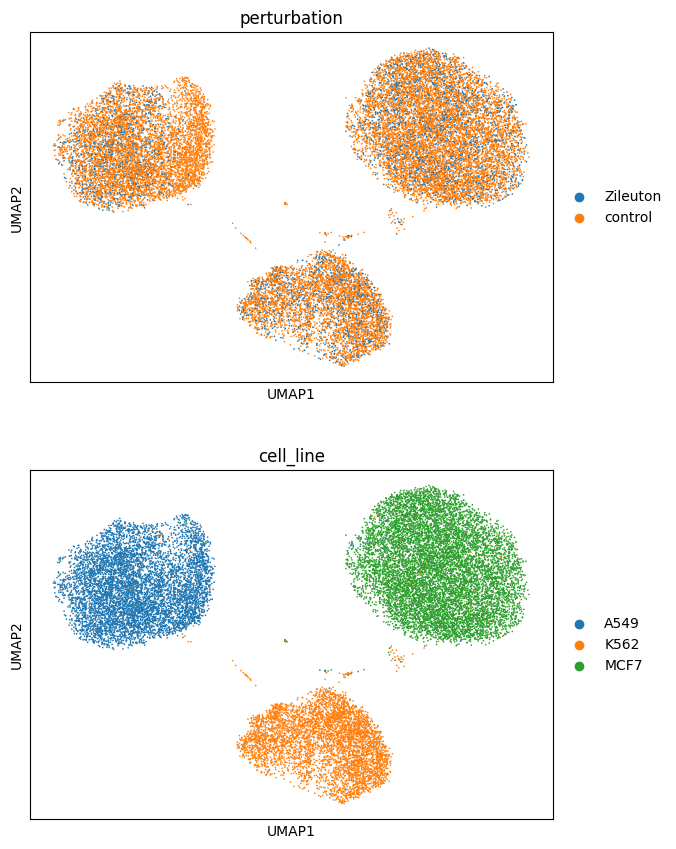

In [22]:
sc.pl.umap(adata_red, color=["perturbation", "cell_line"], ncols=1)

In [80]:
sp = SinkhornProblem(adata_red)
sp = sp.prepare(key="perturbation", joint_attr="X_pca", policy="explicit", subset=[("control", "Zileuton")]) #TODO make more drugs with star policy
sp = sp.solve(1e-2, 0.95, 0.95)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(17578, 4052)].                                         


In [81]:
sp

SinkhornProblem[('control', 'Zileuton')]

We can verify that the transport plan we learn is meaningful, as cell types are mapped onto themselves.

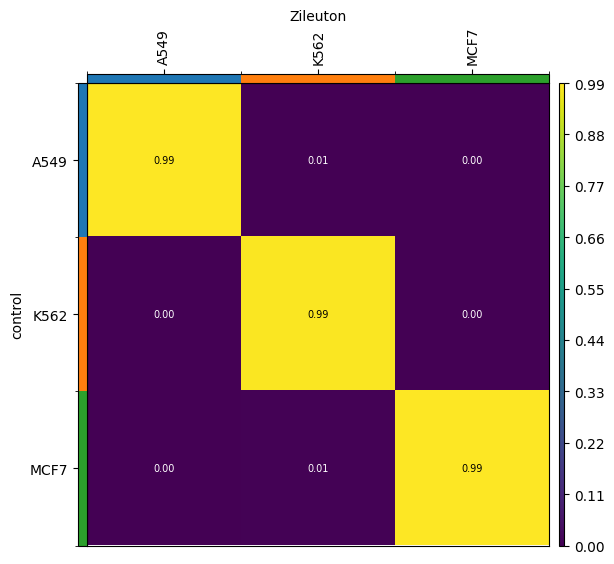

In [83]:
transition_matrix = sp.cell_transition("control", "Zileuton", "cell_line", "cell_line")
mtp.cell_transition(sp)

In [84]:
sc.tl.leiden(
    adata_red, key_added="new_clusters", resolution=0.9
)

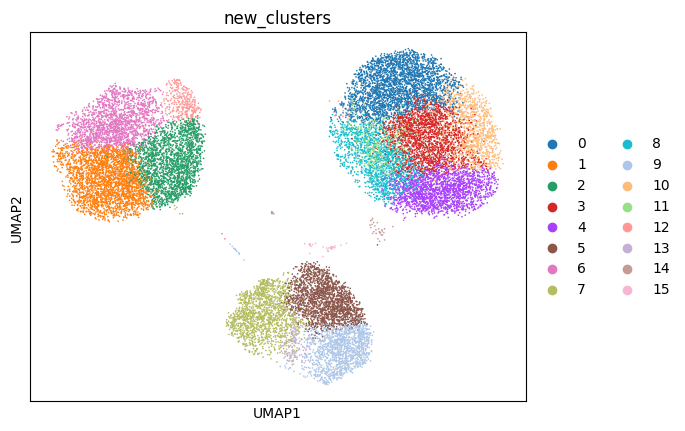

In [85]:
sc.pl.umap(adata_red, color=["new_clusters"])

We now choose cluster 5 and see where it comes from

In [89]:
key_added = "my_push_1"
sp.push(source="control", target="Zileuton", data="new_clusters", subset="14", key_added=key_added)

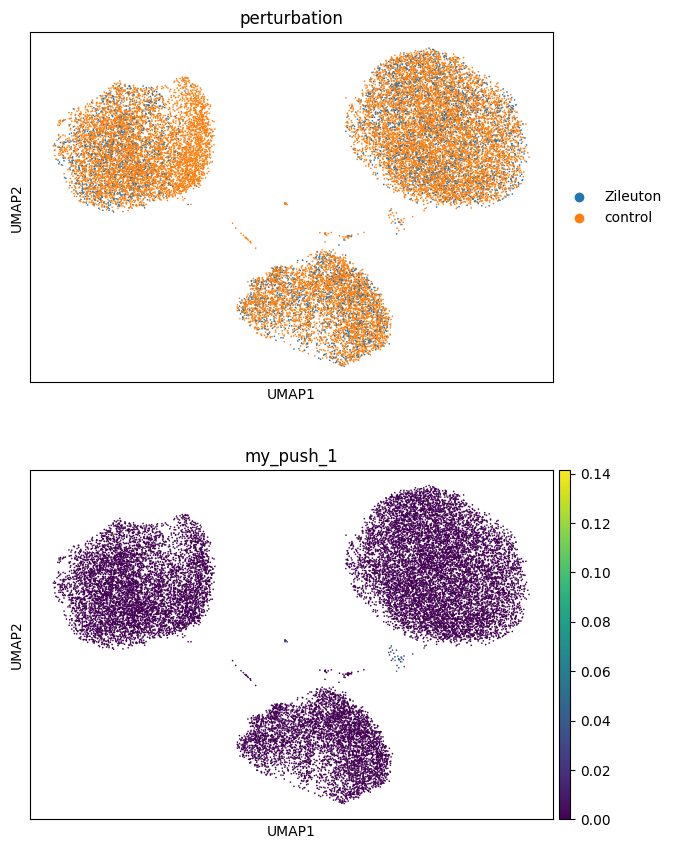

In [91]:
sc.pl.umap(adata_red, color=["perturbation", key_added], ncols=1)

Let's do the same for another cluster which is a bit bigger.

In [92]:
key_added = "my_push_2"
sp.push(source="control", target="Zileuton", data="new_clusters", subset="3", key_added=key_added)

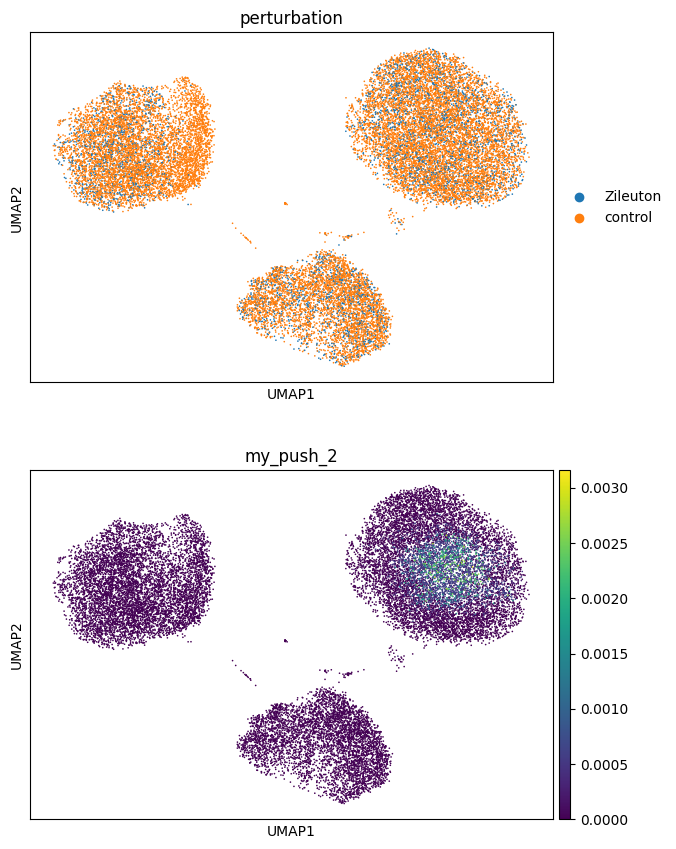

In [93]:
sc.pl.umap(adata_red, color=["perturbation", key_added], ncols=1)